In [1]:
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
trainset = datasets.SVHN(root='data/', split='train',download=True,
                        transform = transforms.ToTensor())

testset = datasets.SVHN(root='data/', split='test', download=True,
                       transform = transforms.ToTensor())

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [3]:
batch_size = 64
num_labels = 10
epochs = 10

In [4]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = batch_size, shuffle=True)

In [12]:
model = timm.create_model('resnext101_32x4d')
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=num_labels, bias=True),
    nn.LogSoftmax(dim=1)
)

In [13]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

indices = []
loss_list = []
train_correct = 0
model.train()
for epoch in range(epochs):
    for data, target in trainloader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss.backward()
        optimizer.step()

    print("Epoch: {:.0f}\tLoss: {:.6f}".format(epoch, loss.item()))
    loss_list.append(loss.item())
    indices.append(epoch)

print("\nTraining accuracy: {}/{} ({:.2f}%)\n".format(
      train_correct, len(trainloader.dataset)*epochs,
      100. * train_correct / (len(trainloader.dataset)*epochs)))


Epoch: 0	Loss: 0.547574
Epoch: 1	Loss: 0.624514
Epoch: 2	Loss: 0.471506
Epoch: 3	Loss: 0.263810
Epoch: 4	Loss: 0.143922
Epoch: 5	Loss: 0.455031
Epoch: 6	Loss: 0.042607
Epoch: 7	Loss: 0.220648
Epoch: 8	Loss: 0.183929
Epoch: 9	Loss: 0.163268

Training accuracy: 671829/732570 (91.71%)



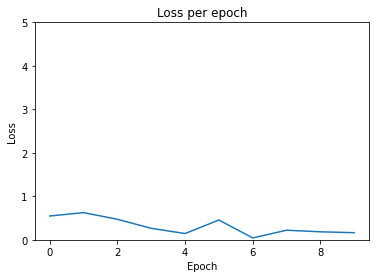

In [15]:
plt.plot(indices, loss_list)
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 5)
plt.show()

In [16]:
with torch.no_grad():            
  model.eval()
  test_loss = 0
  test_correct = 0
  for data, target in testloader:
      data, target = Variable(data), Variable(target)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').data
      pred = output.data.max(1, keepdim=True)[1]
      test_correct += pred.eq(target.data.view_as(pred)).cpu().sum()

test_loss /= len(testloader.dataset)
print('Test set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)'.format(
      test_loss, test_correct, len(testloader.dataset),
      100. * test_correct / len(testloader.dataset)))

Test set: Average loss: 0.2970, Test Accuracy: 23996/26032 (92.18%)
